<p>
<img src="http://www.cerm.unifi.it/chianti/images/logo%20unifi_positivo.jpg" 
        alt="UniFI logo" style="float: left; width: 20%; height: 20%;">
<div align="right">
Massimo Nocentini<br>
<small>
<br>December 3 and 4, 2018: types definitions, gfs
</small>
</div>
</p>
<br>
<div align="center">
<b>Abstract</b><br>
In this document we collect a naive <i>type system</i> based on sets.
</div>

In [1]:
from functools import lru_cache, reduce
import operator

from sympy import *

In [3]:
%run src/commons.py

---

In [2]:
init_printing()

In [8]:
x,y,t,z = symbols('x y t z')
alpha, beta, gamma = symbols(r'\alpha \beta \gamma')

In [126]:
class ty:
    
    def __init__(self, *types):
        self.types = types # the list of types that I depend on.
    
    def tyvars(self):
        vs = map(operator.methodcaller('tyvars'), self.types)
        return reduce(operator.or_, vs, set())
    
    def label(self):
        raise NotImplemented # I'm an abstract type, nameless indeed.
    
    def gf_lhs(self):
        L = Function(self.label())
        return L(*self.tyvars())
    
    def gf(self):
        return define(self.gf_lhs(), self.gf_rhs())
        
    def gf_rhs(self):
        return self.definition().gf_rhs()
    
    def definition(self):
        raise NotImplemented
    
    def __or__(self, other):
        return du(self, other)
    
    def __mul__(self, other):
        return cp(self, other)

In [254]:
class cp(ty):
        
    def gf_rhs(self):
        R = map(lambda t: t.gf().rhs, self.types)
        return reduce(operator.mul, R, 1)
        
    def label(self):
        return r'\times'

In [255]:
(var(x) * var(y) * var(z)).gf()

In [256]:
class du(ty):
    
    def label(self):
        return r'\cup'
            
    def gf_rhs(self):
        R = map(lambda t: t.gf().rhs, self.types)
        return reduce(operator.add, R, 0)

In [257]:
(var(x) | var(y) | var(z)).gf()

In [202]:
class var(ty):
    
    def __init__(self, sym):
        self.sym = sym

    def label(self):
        return self.sym.name
        
    def gf_lhs(self):
        return self.sym
        
    def gf_rhs(self):
        return self.sym
    
    def tyvars(self):
        args = self.sym.args
        return set(args) if args else set([self.sym])
    
class unit(var):
    
    def __init__(self):
        super().__init__(S(1))
        
    def label(self):
        return 'unit'
        
    def tyvars(self):
        return set()

In [203]:
boolean = var(x) | var(y)

In [188]:
class maybe(ty):
    
    def alpha(self):
        alpha, = self.types
        return alpha
    
    def definition(self):
        return unit() | self.alpha()
    
    def label(self):
        return r'\mathcal{M}'

In [258]:
maybe(var(alpha)).gf()

In [323]:
class rec(ty):
    
    def me(self):
        return var(self.gf_lhs())
    
    def gf(self, constraints={}):
        eq = super().gf()
        lhs = self.gf_lhs()
        sols = solve(eq, lhs)
        #print(sols)
        for sol in sols:
            for k,v in constraints.items():
                with lift_to_Lambda(eq) as feq:
                    print(feq(*k).simplify())
                    if feq(*k).simplify() != v:
                        break
            else:  
                return Eq(lhs, sol)
        raise ValueError

In [326]:
class lst(rec):
         
    def definition(self):
        alpha, = self.types
        return unit() | (alpha * self.me())
    
    def label(self):
        return r'\mathcal{L}'

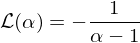

In [327]:
lst_of_alpha_tyeq = lst(var(alpha)).gf()
lst_of_alpha_tyeq

In [262]:
lst_of_alpha_tyeq.rhs.series(alpha, n=10)

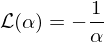

In [263]:
lst_of_maybe_of_alpha_tyeq = lst(maybe(var(alpha))).gf()
lst_of_maybe_of_alpha_tyeq

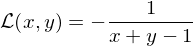

In [233]:
lst_of_boolean_tyeq = lst(boolean).gf()
lst_of_boolean_tyeq

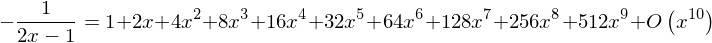

In [235]:
with lift_to_Lambda(lst_of_boolean_tyeq) as L:
    l = L(x,x)
Eq(l, l.series(x,n=10))

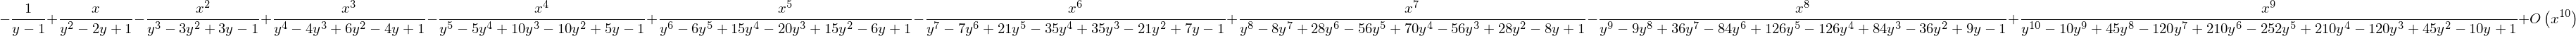

In [142]:
s = lst_of_boolean_tyeq.rhs.series(x, n=10)
s

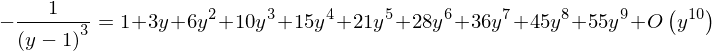

In [121]:
s2 = s.coeff(x,2).factor()
Eq(s2, s2.series(y,n=10))

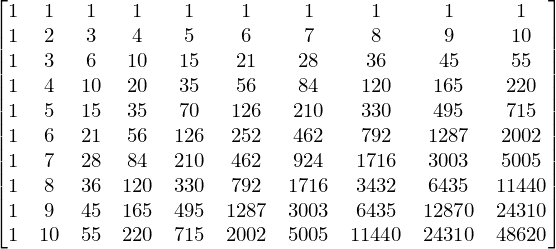

In [122]:
@lru_cache(maxsize=None)
def col(j):
    return lst_of_boolean_tyeq.rhs.series(x,n=dim).coeff(x,j).series(y,n=dim)

dim = 10
Matrix(dim, dim, lambda i,j: col(j).coeff(y,i))

In [264]:
class bin_tree(rec):
    
    def definition(self):
        alpha, = self.types
        return unit() | (alpha * self.me() * self.me())
    
    def label(self):
        return r'\mathcal{B}'

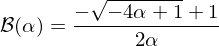

In [265]:
bin_tree_gf = bin_tree(var(alpha)).gf(constraints={(0,):1})
bin_tree_gf

In [266]:
bin_tree_gf.rhs.series(alpha, n=10)

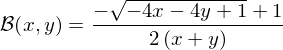

In [267]:
bin_tree_of_boolean = bin_tree(boolean).gf(constraints={(0,0):1})
bin_tree_of_boolean

In [163]:
s = bin_tree_of_boolean.rhs.series(x)

In [164]:
coeffs = [s.coeff(x,i).simplify() for i in range(6)]

In [165]:
ys = [c.series(y,n=10) for c in coeffs]
ys

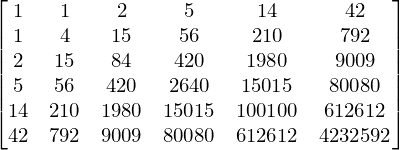

In [166]:
@lru_cache(maxsize=None)
def col(j):
    return s.coeff(x,j).simplify().series(y,n=dim)

dim = 6
Matrix(dim, dim, lambda i,j: ys[i].coeff(y,j))

In [268]:
w = IndexedBase('w')

In [269]:
occupancy = cp(*[unit() | var(w[i]*x) for i in range(3)]).gf()
occupancy

In [270]:
occupancy.rhs.series(x)

In [271]:
with lift_to_Lambda(occupancy) as O:
    o = O(1,x,1,1)
o.series(x)

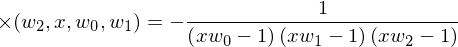

In [272]:
occupancy = cp(*[lst(var(w[i]*x)) for i in range(3)]).gf()
occupancy

In [273]:
occupancy.rhs.series(x)

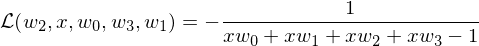

In [274]:
occupancy = lst(var(w[0]*x) | var(w[1]*x) | var(w[2]*x) | var(w[3]*x)).gf()
occupancy

In [225]:
occupancy.rhs.series(x)

In [345]:
class lst_structure_w(rec):
         
    def definition(self):
        alpha, = self.types
        me = self.me()
        return alpha | (lst(me))
    
    def label(self):
        return r'\mathcal{L}_{w}' # `_s` stands for "structure"

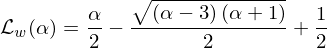

In [346]:
lst_structure_w(var(alpha)).gf(constraints={})

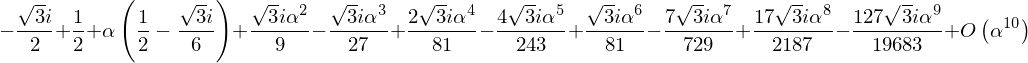

In [347]:
_.rhs.series(alpha,n=10)

In [328]:
class lst_structure(rec):
         
    def definition(self):
        alpha, = self.types
        me = self.me()
        return alpha | (lst(me) * me * me)
    
    def label(self):
        return r'\mathcal{L}_{s}' # `_s` stands for "structure"

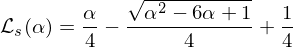

In [337]:
lst_structure(var(alpha)).gf(constraints={})

In [338]:
_.rhs.series(alpha,n=10)

In [335]:
class tree(rec):
         
    def definition(self):
        alpha, = self.types
        return alpha * lst(self.me())
    
    def label(self):
        return r'\mathcal{T}' # `_s` stands for "structure"

0


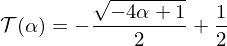

In [336]:
tree(var(alpha)).gf(constraints={(0,):0})

In [334]:
_.rhs.series(alpha, n=10)

In [351]:
class combination(rec):
         
    def definition(self):
        alpha, = self.types
        me = self.me()
        return alpha | (me * me)
    
    def label(self):
        return r'\mathcal{C}' # `_s` stands for "structure"

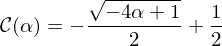

In [354]:
combination(var(alpha)).gf(constraints={})

In [355]:
_.rhs.series(alpha, n=10)

In [356]:
class ab_tree(rec):
         
    def definition(self):
        alpha, beta, = self.types
        me = self.me()
        return beta | (alpha * me * me)
    
    def label(self):
        return r'\mathcal{T}_{a,b}' # `_s` stands for "structure"

0


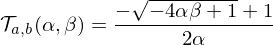

In [360]:
ab_tree(var(alpha), var(beta)).gf(constraints={(0,0):0})

In [361]:
_.rhs.series(beta, n=10)

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.